In [ ]:
!pip install pytorch-crf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
from torchcrf import CRF
from tqdm import tqdm
from tabulate import tabulate
import unicodedata
from math import floor
import numpy as np
from pathlib import Path

PRF = Path('drive/MyDrive/knedle-data/')

In [ ]:
# !unzip drive/MyDrive/knedle-data/segmentation_aposentadoria.zip -d drive/MyDrive/knedle-data/

# Parte 1 - Criando o dataset

In [ ]:
emb = KeyedVectors.load_word2vec_format("drive/MyDrive/knedle-data/cbow_s50.txt")

In [ ]:
class segmentation_dataset(Dataset):
    def __init__(self, tag2idx, word2idx, set_type, path='seg_data.txt'):
        """
        Load the segmentation dataset, (self.__load__())
        Truncate long sentences/split long blocks/ignore very short blocks (self.__trunc__())
        get indices of words and tags (self.__get_idx__())
        PAD the sentences and blocks/create MASKS representing padded elements (self.__pad__())
        """
        self.set_type = set_type
        self.min_block_length = 3
        self.max_sentence_length = 30
        self.max_block_length = 20
        self.path = path

        self.__load__()
        self.__trunc__()
        self.__split__()
        self.__get_idx__(tag2idx, word2idx)
        self.__pad__()
        
        self.x = torch.LongTensor(self.x)
        self.y = torch.LongTensor(self.y)
        self.mask = torch.ByteTensor(self.mask)
        
    def __getitem__(self, index):
        """
        Get one item from the dataset
        """
        return self.x[index], self.mask[index], self.y[index]
    
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.x)
    
    def __load__(self):
        """
        Load raw dataset from `self.path`
        """
        data = open(self.path, 'r').read().splitlines()
        x, y, temp_x, temp_y = [], [], [], []
        for line in data:
            if not line:
                if len(temp_x)>0:
                    x.append(temp_x)
                    y.append(temp_y)
                temp_x, temp_y = [], []
            else:
                if len(line.split())>=2:
                    temp_x.append(line[1:].split())
                    temp_y.append(line[0])
        if temp_x:
            x.append(temp_x)
            y.append(temp_y)
        
        self.x = x
        self.y = y
        
    def __trunc__(self):
        """
        Truncate sentences with length > max_sentence_length
        Separate blocks with length > max_block_length
        Delete blocks with length < min_block_length
        """
        # For each block in x
        # for i in range(len(self.x)):
        for i, x_i in enumerate(self.x):
            # For each sentence in x[i]
            for j, x_ij in enumerate(x_i):
            # for j in range(len(self.x[i])):
                if len(x_ij) > self.max_sentence_length:
                # if len(self.x[i][j]) > self.max_sentence_length:
                    self.x[i][j] = x_ij[:self.max_sentence_length]

        sep_x = []
        sep_y = []
        # for i in range(len(self.x)):
        maxbl = self.max_block_length
        for i, x_i in enumerate(self.x):
            # if len(self.x[i]) > self.max_block_length:
            if len(x_i) > maxbl:
                for j in range( (len(x_i) // maxbl) +1):
                # for j in range( (len(x_i) // self.max_block_length) +1):
                    # if self.x[i][j*self.max_block_length:(j+1)*self.max_block_length]:# and 'B' in self.y[i]:
                    # if x_i[j*self.max_block_length:(j+1)*self.max_block_length]:# and 'B' in self.y[i]:
                    if x_i[ j * maxbl : (j+1) * maxbl]:# and 'B' in self.y[i]:
                        # sep_x.append(self.x[i][j*self.max_block_length:(j+1)*self.max_block_length])
                        sep_x.append(x_i[j * maxbl : (j+1) * maxbl])
                        # sep_y.append(self.y[i][j*self.max_block_length:(j+1)*self.max_block_length])
                        sep_y.append(self.y[i][j * maxbl : (j+1) * maxbl])
            elif len(x_i) < self.min_block_length:
            # elif len(self.x[i]) < self.min_block_length:
                continue
#             elif 'B' in self.y[i]:
            else:
                # sep_x.append(self.x[i])
                sep_x.append(x_i)
                sep_y.append(self.y[i])
        self.x = sep_x
        self.y = sep_y
        
    def __split__(self):
        train_split = floor(0.6*len(self.x))
        valid_split = floor(0.1*len(self.x)) + train_split 
        if self.set_type == 'train':
            print("Treinamento")
            self.x = self.x[:train_split]
            self.y = self.y[:train_split]
        elif self.set_type == 'valid':
            print("validacao")
            self.x = self.x[train_split:valid_split]
            self.y = self.y[train_split:valid_split]
        else:
            print("teste")
            self.x = self.x[valid_split:]
            self.y = self.y[valid_split:]
        
    def __get_idx__(self, tag2idx, word2idx):
        """
        Convert words (x) into indices for the embedding layer
        PADs sentences to self.max_sentence_length
        Convert tags (y) into indices 
        """
        # get_idx of x
        for i in range(len(self.x)):
            for j in range(len(self.x[i])):
                for k in range(len(self.x[i][j])):
                    w = self.x[i][j][k].replace(',', '').replace(';', '').replace(':', '').lower()
                    if w in word2idx:
                        self.x[i][j][k] = word2idx[w]
                    else:
                        self.x[i][j][k] = 0
                while(len(self.x[i][j]) < self.max_sentence_length):
                    self.x[i][j].append(0)
                
        # get_idx of y      
        for i in range(len(self.y)):
            for j in range(len(self.y[i])):
                self.y[i][j] = tag2idx[self.y[i][j]]
                
    def __pad__(self):
        """
        Pad blocks of sentences to self.max_block_length
        Creates MASKS to indicate padded sentences in each block
        """
        self.mask = []
        sent_padder = [0 for i in range(self.max_sentence_length)]
        for i in range(len(self.x)):
            temp_mask = [0 for i in range(self.max_block_length)]
            for j in range(len(self.x[i])):
                temp_mask[j] = 1
            self.mask.append(temp_mask)
            while len(self.x[i]) < self.max_block_length:
                self.x[i].append(sent_padder)
                self.y[i].append(-1)
                

In [ ]:
import unicodedata

dic = {}
for j in emb.wv.index2word:
    num = emb.vocab[j].index
    word = unicodedata.normalize('NFKD', j).encode('ascii', 'ignore').decode('utf8')
    dic[word] = emb.vocab[j].index
print(len(dic))

dic_tag = {'B': 0, 'I': 1, 'O': 2}
idx2tag = {0: 'B', 1:'I', 2:'O'}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


866822


In [ ]:
!ls drive/MyDrive/knedle-data

cbow_s50.txt  seg_data.txt		      seg_model_256_50dim_adam
cbow_s50.zip  segmentation_aposentadoria.zip


In [ ]:
seg_path = 'drive/MyDrive/knedle-data/seg_data.txt'
train_dataset = segmentation_dataset(
    tag2idx=dic_tag,
    word2idx=dic, 
    set_type='train', path=seg_path,)
valid_dataset = segmentation_dataset(
    tag2idx=dic_tag, 
    word2idx=dic, 
    set_type='valid', path=seg_path,)
test_dataset = segmentation_dataset(
    tag2idx=dic_tag, 
    word2idx=dic, 
    set_type='test', path=seg_path,)
len(train_dataset.x), len(valid_dataset.x), len(test_dataset.x)

Treinamento
validacao
teste


(81132, 13522, 40566)

In [ ]:
print("Numero de classes por conjunto de dados (treinamento, validacao e teste)")

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in train_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de treinamento:", tags)

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in valid_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de validacao:", tags)

# tags = {'B':0, 'I':0, 'O':0}
tags = [0, 0, 0]
for block in test_dataset.y:
    for tag in block:
        tags[tag] += 1
print("Conjunto de teste:", tags)

Numero de classes por conjunto de dados (treinamento, validacao e teste)
Conjunto de treinamento: [3613, 10768, 1608259]
Conjunto de validacao: [518, 1464, 268458]
Conjunto de teste: [1251, 3875, 806194]


In [ ]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size=32, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True)
valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True)
test_dataloader  = DataLoader(
    dataset = test_dataset , 
    batch_size=32, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True)

# Parte 2 - Criando o modelo

In [ ]:
import time
import copy
import json

def devicefy(lis, device):
  return [i.to(device) for i in lis]

DUMP_PATH = PRF / "seg_model_256_50dim_adam"

class LSTM_CRF(nn.Module):
    def __init__(self, embedding_dim, num_tags, hidden_dim, 
                 pretrained_emb, idx2tag, dump_path):
        super(LSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_tags = num_tags
        self.hidden_dim = hidden_dim
        self.embed_layer       = nn.Embedding.from_pretrained(
            torch.FloatTensor(pretrained_emb.vectors)
            # torch.FloatTensor(pretrained_emb)
        )

        self.idx2tag_dict = idx2tag
        self.dump_path = dump_path


        # Defining all the nn layers
        
        # Bias
        self.embed_layer.weight[0] = 0
        
        self.word_LSTM_layer   = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=1, batch_first=True
        )
        self.sent_LSTM_layer   = nn.LSTM(
            hidden_dim, hidden_dim // 4, num_layers=1, batch_first=True
        )
        self.linear_layer      = nn.Linear(hidden_dim//4, num_tags)
        self.crf_layer         = CRF(num_tags, batch_first=True)

        # Set device for training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, batch_input, batch_tags):
        """
        Method to compute the forward pass of the LSTM_CRF model
        Input: (x) shape:        (batch_size) x (sequence_length) x (sentence_length)
               (y) shape:        (batch_size) x (sequence_length)
        output: log_likelihood  of the probability of the expected sequence of tags
        """
        batch_size = batch_input.shape[0]
        sequence_pad_size = batch_input.shape[1]
        sentence_pad_size = batch_input.shape[2]
        
        # Embedding Layer
        emb_out = self.embed_layer(batch_input)
        # Word level LSTM layer
        word_lstm_out, (hn, cn) = self.word_LSTM_layer(
            emb_out.view(
                batch_size*sequence_pad_size, 
                sentence_pad_size, 
                self.embedding_dim
            )
        )
        # Sentence level LSTM layer
        sent_lstm_out, (hn, cn) = self.sent_LSTM_layer(
            hn.view(
                batch_size,
                sequence_pad_size,
                self.hidden_dim
            )
        )
        # Linear (fully-connected) layer
        lin_out = self.linear_layer(
            sent_lstm_out.reshape(
                batch_size * sequence_pad_size,
                self.hidden_dim//4
            )
        )
        # CRF layer
        return self.crf_layer(
            lin_out.view(
                batch_size,
                sequence_pad_size,
                self.num_tags),
            batch_tags
        )

    def fit(self, epoch, train_loader, eval_loader, **kwargs):
        """
        Method to train the LSTM_CRF model
        Input: 
          (x) shape:
            (number of batches) x (batch_size) x (sequence_length) x (sentence_length)
          (y) shape:
            (number of batches) x (batch_size) x (sequence_length)
        
        output: validation_loss (validation loss over all epochs)
        """
        learning_rate = kwargs.get('lr', 0.01)
        wd = kwargs.get('weight_decay', 1e-4)
            
        validation_loss = []
        min_loss = float('inf')
#         optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, weight_decay=wd)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=wd)
        # TODO: mostrar a duração de tempo de cada época ( time.time() )
        
        best_params = self.state_dict()
        for e in range(epoch):
            print("Epoch:", e, '...')
            # for batch in tqdm(train_loader):
            for i, batch in enumerate(train_loader):
                x, mask, y = devicefy(batch, self.device)
                # Zerar gradiente antes de usar a rede
                self.zero_grad()
                                                
                loss = -self(x, y,)
                loss.backward()
                optimizer.step()
                
            new_loss = self.evaluate(eval_loader, opt='loss')
            
            validation_loss.append(new_loss)
            if new_loss < min_loss:
              st_dict = self.state_dict()
              if str(best_params) == str(st_dict):
                raise ValueError("UUPS!")
              min_loss = new_loss
              best_params = self.state_dict()
                
        torch.save(best_params , self.dump_path)
        return validation_loss
    
            
    def predict(self, batch_input, mask):
        """
        Method to predict segmentation tags
        Input: sequence - shape:(batch_size)x(sequence_size)x(sentence_size)
        output: Predicted tags - shape: (batch_size)x(sequence_size)
        """
        with torch.no_grad():
            batch_size, sequence_pad_size, sentence_pad_size = batch_input.shape

            # Embedding Layer
            emb_out = self.embed_layer(batch_input)
            # Word level LSTM layer
            word_lstm_out, (hn, cn) = self.word_LSTM_layer(
                emb_out.view(
                    batch_size*sequence_pad_size,
                    sentence_pad_size,
                    self.embedding_dim
                )
            )
            # Sentence level LSTM layer
            sent_lstm_out, (hn, cn) = self.sent_LSTM_layer(
                hn.view(
                    batch_size, 
                    sequence_pad_size, 
                    self.hidden_dim
                )
            )
            # Linear (fully-connected) layer
            lin_out = self.linear_layer(
                sent_lstm_out.reshape(
                    batch_size * sequence_pad_size,
                    self.hidden_dim // 4
                )
            )
            # CRF layer
            return self.crf_layer.decode(
                lin_out.view(
                    batch_size, sequence_pad_size, self.num_tags
                ),
                mask=mask
            )

    def evaluate(self, valid_loader, opt):
        """
        Method to evaluate trained model on unseen data
        """
        print("whoami? ", type(self))
        if opt == 'loss':
            with torch.no_grad():
                loss = 0
                for batch in valid_loader:
                    x, mask, y = devicefy(batch, self.device)                    
                    loss -= self(x, y, )
                return loss
        
        elif opt == 'f1':
            TP, FP, FN = np.zeros((3, 3), int)
            with torch.no_grad():
                for batch in tqdm(valid_loader):
                    x, mask, y = devicefy(batch, self.device, )

                    pred = self.predict(x, mask)
                    for i, p_i in enumerate(pred):
                        for j, p_ij in enumerate(pred[i]):
                            if y[i][j] == -1:
                                break
                            if p_ij == y[i][j]:
                                TP[p_ij] += 1
                            else:
                                FP[p_ij] += 1
                                FN[y[i][j]] += 1

            recall = TP/(TP+FN)
            precision = TP/(TP+FP)
            f1_score = 2*(recall*precision)/(recall+precision)
            print(tabulate([
                ['Recall', recall[0], recall[1], recall[2]], 
                ['Precision', precision[0], precision[1], precision[2]], 
                ['F1 score', f1_score[0], f1_score[1], f1_score[2]]
                ], 
                headers=['', self.idx2tag_dict[0], self.idx2tag_dict[1], self.idx2tag_dict[2]]
            ))
            return recall, precision, f1_score
        
        else:
            print("Chosen opt doesn't exist")



In [ ]:
model_maffei = LSTM_CRF(
    embedding_dim=50,
    num_tags=3,
    hidden_dim=256,
    pretrained_emb=emb, 
    idx2tag=idx2tag,
    dump_path=DUMP_PATH,
)


model_maffei = model_maffei.to(model_maffei.device)

# model_maffei.evaluate = model_jose.evaluate
# model = model.to(model.device)

In [ ]:
# model_jose.evaluate(test_dataloader, opt='f1')
print("Test set loss:", model_maffei.evaluate(test_dataloader, opt='loss'))

whoami?  <class '__main__.LSTM_CRF'>
Test set loss: tensor(879064.0625, device='cuda:0')


# Parte 3 - Treinamento

In [ ]:
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_reserved())

In [ ]:
valid_loss = model_maffei.fit(
    epoch=2, 
    train_loader = train_dataloader, 
    eval_loader = valid_dataloader, 
    lr=0.001, 
    weight_decay=1e-6,
)

Epoch: 0 ...
whoami?  <class '__main__.LSTM_CRF'>


ValueError: ignored

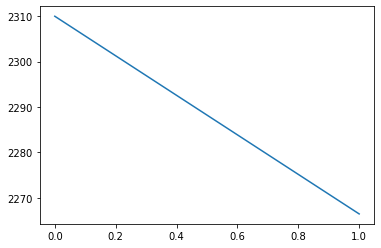

In [ ]:
import matplotlib.pyplot as plt
plt.plot(valid_loss)

# Parte 4 - Avaliacao do modelo no conjunto de teste

In [ ]:
# model.load_state_dict(torch.load(DUMP_PATH))

In [ ]:
# model_jose.evaluate(test_dataloader, opt='f1')
print("Test set loss:", model_maffei.evaluate(test_dataloader, opt='loss'))

WHOAM I <class '__main__.LSTM_CRF'>
Test set loss: tensor(6079.5044, device='cuda:0')


# Parte 5 - Salvando o modelo

In [ ]:
# To save trained pytorch model
# torch.save(model.state_dict(), "seg_model_256")

# # To load trained pytorch model
# loaded_model = LSTM_CRF(embedding_dim=100, word2idx_dict=dic, num_tags=3, hidden_dim=128)
# new_model.load_state_dict(torch.load("seg_model"))